# Michell Luiz Costalonga

# Exercícios - Módulo 14
<br>

## __Exercício: Detecção de Anomalias__

<br>

__1:__

Utilizando a classe DetectorAnomalias criada ao longo do módulo, __vamos avaliar um detector de anomalias.__

O dataset utilizado pode ser importado através da função getData. 

Nesse conjunto de dados, possuímos 6 variáveis explicativas, $X_1, .., X_6$ e uma variável com a marcação se a instância é uma anomalia ou não.

Utilizando a __metodolodia__ discutida ao longo do módulo, __teste diferentes modelos (variando o limiar $\epsilon$)__ a fim de encontrar o que __melhor fita os dados.__

Justifique as escolhas do $\epsilon$, bem como quais as métricas de performance abordadas. 

In [1]:
# Importando bibliotecas
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# Função para realizar a validação cruzada e separação dos dados
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split

# Métricas de performance (Exercício de regressão logística)
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

# Algoritmo para classificação
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Pre processamento
from sklearn.preprocessing import StandardScaler

# Contar tempo
import time

# ignorar avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Classe para detectar anomalias
class DetectorAnomalias():
    
    def __init__(self, epsilon = 0.0001):
        self.epsilon = epsilon
        
    def fit(self, X):
        medias = X.mean(axis = 0)
        desvios = X.std(axis = 0)
        gaussianas = [st.norm(loc = m, scale = d) for m, d in zip(medias, desvios)]  
        self.gaussianas = gaussianas
        self.X = X
        
    def prob(self, x):
        p = 1
        for i in range(self.X.shape[1]):
            gaussiana_i = self.gaussianas[i]
            x_i = x[i]
            p *= gaussiana_i.pdf(x_i)
        return p
    
    def isAnomaly(self, x):
        return int(np.where(self.prob(x) < self.epsilon, 0, 1))

In [3]:
def getData():
    return pd.read_csv("dataframe_anomalias_exercicio.csv")

In [4]:
df = getData()
df

,x1,x2,x3,x4,x5,x6,anomalia
0,7.731153,23.299155,-0.367453,4.715372,9.306179,16.780965,0.0
1,11.466833,16.943695,-0.245131,7.060311,10.462826,19.821289,0.0
2,11.501272,20.196011,1.206049,-4.957189,7.771262,19.100079,0.0
3,10.893921,16.072385,2.738045,-3.684228,7.373334,23.225524,0.0
4,10.091706,19.253894,0.996895,-9.504052,8.883988,17.903298,0.0
...,...,...,...,...,...,...,...
10095,11.192286,18.451987,-0.953650,-14.362996,10.875826,17.056541,0.0
10096,12.014177,19.461815,1.985099,-7.119190,11.079922,17.582755,0.0
10097,10.745460,18.175951,0.206037,-1.897015,9.888329,17.963324,0.0
10098,9.893969,22.333270,-1.465981,4.137382,7.690620,21.570097,0.0


In [5]:
df.anomalia.value_counts()

0.0    10046
1.0       54
Name: anomalia, dtype: int64

Para usarmos métricas como Precision, Recall e a F1 Score, precisaremos de valores *true positive*. Dessa forma, inverteremos os valores 0 e 1. Dessa forma:

- 0: representa casos em que há anomalia
- 1: representa casos em que não há anomalia

In [6]:
# Trocando 1 por 0 e 0 por 1
df.replace({'anomalia': {0: 1, 1: 0}}, inplace=True)

In [7]:
df.anomalia.value_counts()

1.0    10046
0.0       54
Name: anomalia, dtype: int64

In [8]:
# Separando os dados que apresentam anomalia, dos que não apresentam

df_normal = df[df.anomalia == 1]
df_anomalia = df[df.anomalia == 0]

df_normal.shape, df_anomalia.shape

((10046, 7), (54, 7))

In [9]:
# Função para os dados de treino, validação e teste
def separarDados(df_, porc):
    
    # Especificando o número de linhas para o dataframe A
    ponto_separacao = round(len(df_) * porc)
    
    # Separando o dataframe de entrada (df_) em dois dataframes.
    # df_A possuirá "ponto_separacao" linhas e df_B possuirá o restante das
    # linhas de df_ a partir de "ponto_separacao"
    df_A = df_.iloc[:ponto_separacao].reset_index(drop=True)
    df_B = df_.iloc[ponto_separacao:].reset_index(drop=True)
    
    return df_A, df_B

# Função para juntar os dados de validação/teste normais e com anomalia
def juntarDados(df_1, df_2):
    df_saida = df_1.append(df_2).reset_index(drop=True)
    
    return df_saida

# Função para separar as variáveis independentes da variável independente
# Função para separar as variáveis independentes da variável dependente.
def dividirVDVI(df_):
    verificador = True
    # Loop para separar as variáveis independentes da variável dependente
    for item in df_.columns:
        if (verificador):
            if (item != 'anomalia'):
                X = df_[item].values.reshape(-1,1)
                verificador = False
            else:
                Y = df_[item].values.reshape(-1,1)
                verificador = False
        else:
            if (item != 'anomalia'):
                X = np.c_[X, df_[item].values.reshape(-1,1)]
            else:
                Y = df_[item].values.reshape(-1,1)
            
    # Transformando a lista para um numpy array
    
    return X, Y # Dados de saída

In [10]:
# Criação dos dataframes com os dados de treino, validação e teste.
df_n_treino, df_val_tes = separarDados(df_ = df_normal, porc = 0.8)
df_n_validacao, df_n_teste = separarDados(df_ = df_val_tes, porc = 0.5)
df_a_validacao, df_a_teste = separarDados(df_ = df_anomalia, porc = 0.5)

df_validacao = juntarDados(df_1 = df_n_validacao, df_2 = df_a_validacao)
df_teste = juntarDados(df_1 = df_n_teste, df_2 = df_a_teste)

# Os dataframes que utilizaremos serão os seguintes:
print('Dataframe de treino: %d linhas e %d colunas.' %(df_n_treino.shape[0], df_n_treino.shape[1]))
print('Dataframe de validação: %d linhas e %d colunas.' %(df_validacao.shape[0], df_validacao.shape[1]))
print('Dataframe de Teste: %d linhas e %d colunas.' %(df_teste.shape[0], df_teste.shape[1]))

Dataframe de treino: 8037 linhas e 7 colunas.
Dataframe de validação: 1031 linhas e 7 colunas.
Dataframe de Teste: 1032 linhas e 7 colunas.


Depois de separar os dados, usaremos a função "dividirVDVI" para separar a variável dependente das variáveis independentes.

In [11]:
X_treino, y_treino = dividirVDVI(df_n_treino)
X_val, y_val = dividirVDVI(df_validacao)
X_teste, y_teste = dividirVDVI(df_teste)

Com as variáveis separadas, iremos instanciar o modelo "DetectorAnomalias" e verificar qual o valor de epsilon para os dados apresentados.

In [12]:
# Instanciando a classe DectectorAnomalias (o valor de epsilon foi obtido a partir de np.min logo abaixo)
detector = DetectorAnomalias(epsilon = 7e-9)

# Ajustando o modelo aos dados de treino
detector.fit(X_treino)

In [13]:
# Probabilidade para cada linha do dataframe
probab = []
for item in X_treino:
    probab.append(detector.prob(item))

In [14]:
# Valores mínimo e máximo da probabilidade dos dados de treino.
np.min(probab), np.max(probab)

(7.657363146106533e-09, 7.275090373109252e-05)

Conhecendo o valor mínimo de probabilidade para os dados de treino, podemos configurar o parâmetro epsilon. Nesse caso, foi considerado o valor de $\varepsilon$ = $7 \times 10^{-9}$. Como os dados de treino só possuem dados sem anomalia, o valor predito deve retornar uma contagem de valores 1 igual a zero.

In [15]:
y_pred = []
for item in X_treino:
    y_pred.append(detector.isAnomaly(item))

In [16]:
accuracy = accuracy_score(y_true = y_treino, y_pred = y_pred)
precision = precision_score(y_true = y_treino, y_pred = y_pred)
recall = recall_score(y_true = y_treino, y_pred = y_pred)
f1 = f1_score(y_true = y_treino, y_pred = y_pred)
cm = confusion_matrix(y_true = y_treino, y_pred = y_pred)
df_cm = pd.DataFrame(np.c_[cm],
                     columns = ['Sem anom. (P)'],
                     index = ['Sem anom. (R)'])

print('Accuracy score: %s' %accuracy)
print('Precision score: %s' %precision)
print('Recall score: %s' %recall)
print('F1 score: %s' %f1)
df_cm

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


,Sem anom. (P)
Sem anom. (R),8037


Com os scores acima, vemos que o modelo se ajusta bem aos dados de treino, identificando todos os casos sem anomalias. Antes de determinar o melhor valor de epsilon para o modelo, iremos aplicar o modelo aos dados de validação e teste e comparar o valor das métricas apresentadas.

In [17]:
y_pred_val = []
for item in X_val:
    y_pred_val.append(detector.isAnomaly(item))
    
accuracy = accuracy_score(y_true = y_val, y_pred = y_pred_val)
precision = precision_score(y_true = y_val, y_pred = y_pred_val)
recall = recall_score(y_true = y_val, y_pred = y_pred_val)
f1 = f1_score(y_true = y_treino, y_pred = y_pred)
cm = confusion_matrix(y_true = y_val, y_pred = y_pred_val)
df_cm = pd.DataFrame(np.c_[cm],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])

print('Accuracy score: %s' %accuracy)
print('Precision score: %s' %precision)
print('Recall score: %s' %recall)
print('F1 score: %s' %f1)
df_cm

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


,Com anom. (P),Sem anom. (P)
Com anom. (R),27,0
Sem anom. (R),0,1004


Os resultados acima indicam que o modelo apresenta um bom ajuste aos dados de validação. Por último aplicaremos o modelo aos dados de teste.

In [18]:
y_pred_teste = []
for item in X_teste:
    y_pred_teste.append(detector.isAnomaly(item))
    
accuracy = accuracy_score(y_true = y_teste, y_pred = y_pred_teste)
precision = precision_score(y_true = y_teste, y_pred = y_pred_teste)
recall = recall_score(y_true = y_teste, y_pred = y_pred_teste)
f1 = f1_score(y_true = y_teste, y_pred = y_pred_teste)
cm = confusion_matrix(y_true = y_teste, y_pred = y_pred_teste)
df_cm = pd.DataFrame(np.c_[cm],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])

print('Accuracy score: %s' %accuracy)
print('Precision score: %s' %precision)
print('Recall score: %s' %recall)
print('F1 score: %s' %f1)
df_cm

Accuracy score: 0.998062015503876
Precision score: 0.9980139026812314
Recall score: 1.0
F1 score: 0.9990059642147118


,Com anom. (P),Sem anom. (P)
Com anom. (R),25,2
Sem anom. (R),0,1005


Vemos que o epsilon utilizado permite a identificação de maneira eficiente de casos com e sem anomalia. Entretanto, para os dados de teste, vemos que houveram 2 falsos negativos (2 casos em que havia anomalia, mas foram identificados sem anomalia). Com isso em mente, tentaremos obter um valor de epsilon para maximizar o valor de F1 score, que é a métrica escolhida, uma vez que não sabemos o peso de falsos positivos e falsos negativos. 

Para isso, inverteremos os conjuntos de dados. Os dados de teste serão usados como dados de validação, enquanto os dados de validação passarão a ser os dados de teste.

In [19]:
df_validacao = juntarDados(df_1 = df_n_teste, df_2 = df_a_teste)
df_teste = juntarDados(df_1 = df_n_validacao, df_2 = df_a_validacao)

X_val, y_val = dividirVDVI(df_validacao)
X_teste, y_teste = dividirVDVI(df_teste)

Como vimos anteriormente, para o caso em questão, um bom valor de epsilon para começar é aquele próximo do menor valor de probabilidade obtido dos dados de treino. Com isso em mente, a classe DetectarAnomalia foi modificada para obter esse valor após o ajuste de dados através da função "definirEpsilon". Além disso, foi incluída uma função para fornecer a lista dos valores preditos a partir do modelo ajustado, chamada "predict". Por último, para obter o valor ótimo de epsilon, usaremos a função "variarEpsilon" para atribuir valores e, posteriormente compararmos os resultados. A nova classe foi chamada de "DetectarAnomalia_mod".

In [20]:
class DetectarAnomalia_mod():
    
    def __init__(self, epsilon = 0.0001):
        self.epsilon = epsilon
        
    def fit(self, X):
        medias = X.mean(axis = 0)
        desvios = X.std(axis = 0)
        gaussianas = [st.norm(loc = m, scale = d) for m, d in zip(medias, desvios)]  
        self.gaussianas = gaussianas
        self.X = X
        
    def definirEpsilon(self):
        
        self.lista_prob = []
        
        for item in self.X:
            p = 1
            x = item
            for i in range(self.X.shape[1]):
                gaussiana_i = self.gaussianas[i]
                x_i = x[i]
                p *= gaussiana_i.pdf(x_i)
            self.lista_prob.append(p)
        
        prob_min = np.min(self.lista_prob)
        
        if (self.epsilon > prob_min):
            self.epsilon = prob_min * 0.9999       
    
    def prob(self, x):
        p = 1
        for i in range(self.X.shape[1]):
            gaussiana_i = self.gaussianas[i]
            x_i = x[i]
            p *= gaussiana_i.pdf(x_i)
        return p
    
    def variarEpsilon(self, epsilon):
        self.epsilon = epsilon
    
    def predict(self, X):
        lista_ypred = []
        for item in X:
            lista_ypred.append(self.isAnomaly(item))
        return np.array(lista_ypred)
    
    def isAnomaly(self, x):
        return int(np.where(self.prob(x) < self.epsilon, 0, 1))

In [21]:
# Instanciando a classe
det = DetectarAnomalia_mod()

# Treinando o modelo
det.fit(X_treino)

# Definindo um valor de epsilon
det.definirEpsilon()

Perceba que para a classe modificada, não é necessário fornecer um valor de epsilon ao instanciar a mesma. O valor é definido ao usara função "definirEpsilon". A partir desse valor, criaremos um intervalo onde o valor máximo de epsilon é 15% maior que o valor inicial e o valor mínimo é 15% menor que o valor inicial.

In [22]:
# Faixa de valores para epsilon: dentro desse intervalo, serão testados 100 valores.
faixa_epsilon = np.linspace(1.15 * det.epsilon, 0.85 * det.epsilon, 100)

# Listas para armazenar os valores de F1 score para os dados de validação.
lista_f1_val = []
lista_epsilon = []

for item in faixa_epsilon:

    det.variarEpsilon(item)
    y_pred_val = det.predict(X_val)
    
    lista_epsilon.append(det.epsilon)
    lista_f1_val.append(f1_score(y_true = y_val, y_pred = y_pred_val))
    
    df_comp = pd.DataFrame(np.c_[lista_epsilon, lista_f1_val],
                           columns = ['Epsilon', 'F1 Score'])

In [23]:
df_comp.head()

,Epsilon,F1 Score
0,8.805087e-09,0.999004
1,8.781885e-09,0.999004
2,8.758683e-09,0.999004
3,8.735482e-09,0.999004
4,8.712280e-09,0.999004


In [24]:
best_ep = df_comp['Epsilon'].iloc[df_comp.index[df_comp['F1 Score'] == df_comp['F1 Score'].max()][0]]
print('Epsilon = %s apresentou um F1 score = %s' %(str(best_ep), str(df_comp['F1 Score'].max())))

Epsilon = 7.38977659096584e-09 apresentou um F1 score = 0.9995027349577325


Considerando o valor ótimo para epsilon encontrado acima, iremos comparar os resultados com o primeiro caso, com $\varepsilon$ = $7 \times 10^{-9}$.

In [25]:
det.variarEpsilon(best_ep)
y_pred_treino = det.predict(X_treino)
y_pred_val = det.predict(X_val)
y_pred_teste = det.predict(X_teste)

f1_treino = f1_score(y_true = y_treino, y_pred = y_pred_treino)
f1_val = f1_score(y_true = y_val, y_pred = y_pred_val)
f1_teste = f1_score(y_true = y_teste, y_pred = y_pred_teste)

cm_treino = confusion_matrix(y_true = y_treino, y_pred = y_pred_treino)
cm_val = confusion_matrix(y_true = y_val, y_pred = y_pred_val)
cm_teste = confusion_matrix(y_true = y_teste, y_pred = y_pred_teste)

print('-- F1 score -- \nTreino: %s \nValidação: %s \nTeste: %s' %(str(f1_treino), str(f1_val), str(f1_teste)), end='\n\n')

-- F1 score -- 
Treino: 1.0 
Validação: 0.9995027349577325 
Teste: 1.0



Lembrando que o dataset de validação é o dataset de treino do primeiro caso, vemos que há um aumento no coeficiente F1, uma vez que foi reduzida a quantidade em uma unidade de falsos negativos, como é mostrado na matriz de confusão abaixo.

In [26]:
df_cm_val = pd.DataFrame(np.c_[cm_val],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])

print('Caso ótimo: epsilon = 7.38977659096584e-09')
df_cm_val

Caso ótimo: epsilon = 7.38977659096584e-09


,Com anom. (P),Sem anom. (P)
Com anom. (R),26,1
Sem anom. (R),0,1005


In [27]:
print('Primeiro caso: epsilon = 7e-09')
df_cm

Primeiro caso: epsilon = 7e-09


,Com anom. (P),Sem anom. (P)
Com anom. (R),25,2
Sem anom. (R),0,1005


__2:__ 

Aborde o problema num contexto de aprendizado supervisionado, ou seja, treine modelos de classificação binária com o objetivo de detectar anomalias.

Compare os resultados entre as metodologias.

Para o caso de aprendizado supervisionado, utilizaremos o modelo de regressão logística e, caso necessário, o modelo KNN para classificação.

In [28]:
#adaptação da função validacao_cruzada 
def validacao_cruzada(classificador, 
                      X_data, 
                      y_data, 
                      metrica, 
                      num_folds, 
                      limiar = 0.5, 
                      print_info = False, 
                      nome_metrica = None):
    
    lista_metrica_treino = []
    lista_metrica_validacao = []
    
    kf = KFold(n_splits = num_folds)
    for train_index, val_index in kf.split(X_data, y_data):
        Xtrain_folds = X_data[train_index]
        ytrain_folds = y_data[train_index]
        Xval_fold = X_data[val_index]
        yval_fold = y_data[val_index]
        classificador.fit(Xtrain_folds, ytrain_folds)
        
        #alteração nesta parte! agora, primeiro calculamos a probabilidade e na sequência usamos o valor do limiar
        prob_class1_treino = classificador.predict_proba(Xtrain_folds)[:,1]
        prob_class1_validacao = classificador.predict_proba(Xval_fold)[:,1]
        pred_treino = np.where(prob_class1_treino > limiar, 1, 0)
        pred_validacao = np.where(prob_class1_validacao > limiar, 1, 0)
        
        lista_metrica_treino.append(metrica(y_pred = pred_treino, y_true = ytrain_folds))
        lista_metrica_validacao.append(metrica(y_pred = pred_validacao, y_true = yval_fold))
    if print_info:
        print("Métrica: " + nome_metrica)
        print('média treino:', np.mean(lista_metrica_treino))
        print('média validação:', np.mean(lista_metrica_validacao))
    return lista_metrica_treino, lista_metrica_validacao, classificador

In [29]:
# Dados originais
df.head()

,x1,x2,x3,x4,x5,x6,anomalia
0,7.731153,23.299155,-0.367453,4.715372,9.306179,16.780965,1.0
1,11.466833,16.943695,-0.245131,7.060311,10.462826,19.821289,1.0
2,11.501272,20.196011,1.206049,-4.957189,7.771262,19.100079,1.0
3,10.893921,16.072385,2.738045,-3.684228,7.373334,23.225524,1.0
4,10.091706,19.253894,0.996895,-9.504052,8.883988,17.903298,1.0


In [30]:
df.shape

(10100, 7)

In [31]:
# Dividindo o dataset em treino/validação e teste
dftrain, dftest = train_test_split(df, test_size = 0.2, random_state = 0)
dftrain.shape, dftest.shape

((8080, 7), (2020, 7))

In [32]:
Xtrain, ytrain = dividirVDVI(dftrain)
Xtest, ytest = dividirVDVI(dftest)

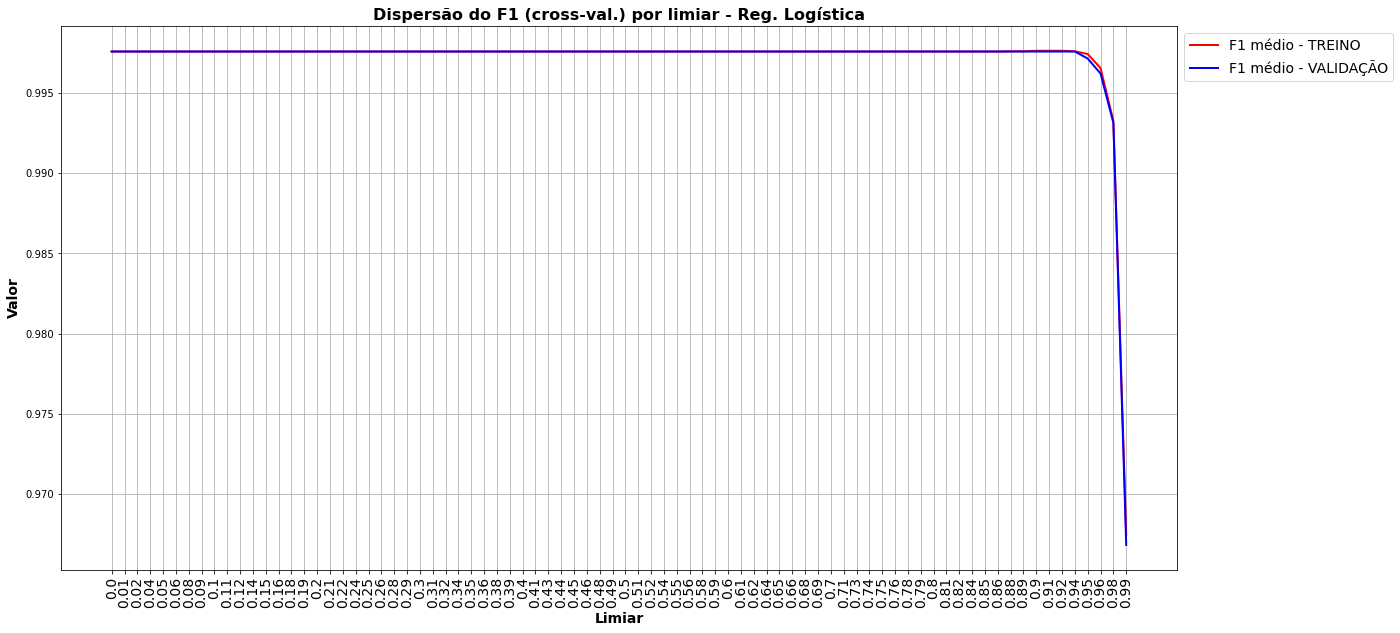

O valor máximo do F1 Score para o treino é 99.76271843747689 % para t = 0.9

O valor máximo do F1 Score para a validação é 99.75803943471114 % para t = 0.0

Tempo de execução: 21.520933389663696 segundos.


In [33]:
threshold = np.arange(0, 1, 0.0125)

lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:
    
    lt, lv, cl = validacao_cruzada(classificador = LogisticRegression(), 
                               X_data = Xtrain, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14, rotation=90)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - Reg. Logística", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(np.max(lista_media_metrica_treino)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(np.max(lista_media_metrica_validacao)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

t1 = time.time()
print('Tempo de execução: %s segundos.' %(t1-t0))

In [34]:
df_comp_lg = pd.DataFrame(np.c_[threshold, lista_media_metrica_treino, lista_media_metrica_validacao],
                         columns = ['Threshold', 'F1 treino', 'F1 val'])

df_comp_lg['Dif.[%]'] = (1 - df_comp_lg['F1 treino'] / df_comp_lg['F1 val'] ) *100

min_dif = abs(df_comp_lg['Dif.[%]']).min(); min_dif

df_comp_lg.head(50)

,Threshold,F1 treino,F1 val,Dif.[%]
0,0.0000,0.997581,0.99758,-0.000038
1,0.0125,0.997581,0.99758,-0.000038
2,0.0250,0.997581,0.99758,-0.000038
3,0.0375,0.997581,0.99758,-0.000038
4,0.0500,0.997581,0.99758,-0.000038
5,0.0625,0.997581,0.99758,-0.000038
6,0.0750,0.997581,0.99758,-0.000038
7,0.0875,0.997581,0.99758,-0.000038
8,0.1000,0.997581,0.99758,-0.000038
9,0.1125,0.997581,0.99758,-0.000038


Vemos que o valor de F1 score para os dados de validação permanece constante até o valor de threshold igual a 0.9375. Com isso em mente, manteremo o limiar padrão t = 0,5, uma vez que não há alteração significativa no valor de F1 score. Assim, realizaremos o treino do modelo usando esse limiar e aplicaremos o modelo aos dados de teste para avaliar o resultado.

In [35]:
lt, lv, cl = validacao_cruzada(classificador = LogisticRegression(), 
                               X_data = Xtrain, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = 0.5)
    
f1_treino = np.mean(lt)
f1_validacao = np.mean(lv)

print('O valor médio do F1 Score para os dados treino é ', end='')
print(str(f1_treino * 100) + ' %.')

print('O valor médio do F1 Score para os dados de validação é ', end='')
print(str(f1_validacao * 100) + ' %.')

y_pred_test = cl.predict(Xtest)
f1_test = f1_score(y_true = ytest, y_pred = y_pred_test)

print('O valor do F1 Score para os dados de teste é ', end='')
print(str(f1_test * 100) + ' %.')

O valor médio do F1 Score para os dados treino é 99.75807701606445 %.
O valor médio do F1 Score para os dados de validação é 99.75803943471114 %.
O valor do F1 Score para os dados de teste é 99.62732919254658 %.


In [36]:
cm_lg_tr = confusion_matrix(y_true = ytrain, y_pred = cl.predict(Xtrain))
df_cm_lg_tr = pd.DataFrame(np.c_[cm_lg_tr],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de treino')
df_cm_lg_tr

Matriz de confusão: Dados de treino


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,39
Sem anom. (R),0,8041


In [37]:
cm_lg = confusion_matrix(y_true = ytest, y_pred = y_pred_test)
df_cm_lg = pd.DataFrame(np.c_[cm_lg],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de teste')
df_cm_lg

Matriz de confusão: Dados de teste


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,15
Sem anom. (R),0,2005


Vemos que o modelo de regressão logística apresenta uma alta consistência nos resultados se considerarmos apenas os valores dos F1 scores calculados para os dados de treino/validação e teste. Entretanto, ao avaliar a matriz de confusão, vemos que tanto para os dados de treino, quanto para os dados de teste, o modelo não é capaz de identificar os casos em que há anomalia. O valor do F1 score é alto, uma vez que há poucos dados com anomalia. Com isso em mente, vemos que o modelo de regressão logística não é adequado para esse caso. 

Testaremos o modelo KNN de classificação para verificar se ocorre o mesmo. Testaremos o modelo com K igual a 1 até 50, com um passo igual a 2. Além disso, como comentado anteriormente, como apenas 0,53% dos dados apresentam anomalia, consideraremos o limiar padrão de 0.5.

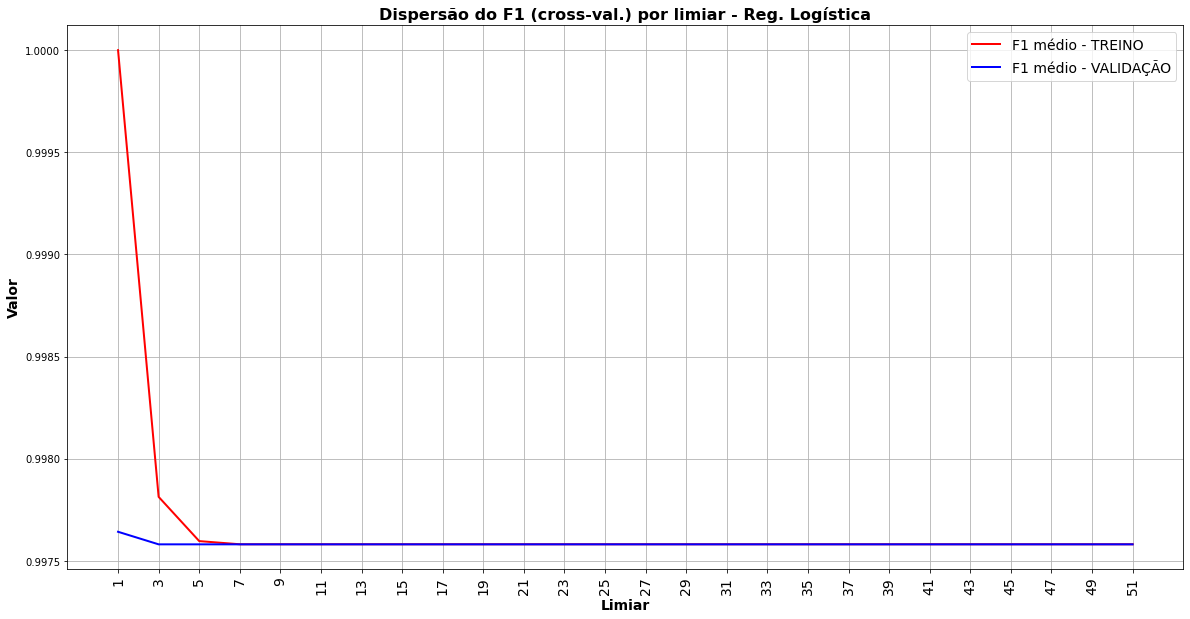

O valor máximo do F1 Score para o treino é 100.0 % para K = 1

O valor máximo do F1 Score para a validação é 99.76419091287558 % para K = 1

Tempo de execução: 46.13685655593872 segundos.


In [38]:
num_viz = np.arange(1, 52, 2)

lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for viz in num_viz:
    
    lt, lv, cl = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=viz), 
                               X_data = Xtrain, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = 0.5)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(num_viz)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(num_viz)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(num_viz)), num_viz.round(2), fontsize = 14, rotation=90)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - Reg. Logística", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(np.max(lista_media_metrica_treino)*100) + ' %', end=' ')
print('para K = ', end='')
print(num_viz[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(np.max(lista_media_metrica_validacao)*100) + ' %', end=' ')
print('para K = ', end='')
print(num_viz[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

t1 = time.time()
print('Tempo de execução: %s segundos.' %(t1-t0))

Vemos que para K = 1, obtemos um valor para F1 score = 1 e ao ser aplicado aos dados de validação, o F1 score é reduzido apra 0.9975. Inicialmente, testaremos o modelo com essa configuração.

In [39]:
lt, lv, cl = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors = 1), 
                               X_data = Xtrain, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = 0.5)
    
f1_treino = np.mean(lt)
f1_validacao = np.mean(lv)

print('O valor médio do F1 Score para os dados treino é ', end='')
print(str(f1_treino * 100) + ' %.')

print('O valor médio do F1 Score para os dados de validação é ', end='')
print(str(f1_validacao * 100) + ' %.')

y_pred_test = cl.predict(Xtest)
f1_test = f1_score(y_true = ytest, y_pred = y_pred_test)

print('O valor do F1 Score para os dados de teste é ', end='')
print(str(f1_test * 100) + ' %.')

O valor médio do F1 Score para os dados treino é 100.0 %.
O valor médio do F1 Score para os dados de validação é 99.76419091287558 %.
O valor do F1 Score para os dados de teste é 99.65174129353234 %.


In [40]:
cm_knn_tr = confusion_matrix(y_true = ytrain, y_pred = cl.predict(Xtrain))
df_cm_knn_tr = pd.DataFrame(np.c_[cm_knn_tr],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de treino')
df_cm_knn_tr

Matriz de confusão: Dados de treino


,Com anom. (P),Sem anom. (P)
Com anom. (R),30,9
Sem anom. (R),0,8041


In [41]:
cm_knn = confusion_matrix(y_true = ytest, y_pred = y_pred_test)
df_cm_knn = pd.DataFrame(np.c_[cm_knn],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de teste')
df_cm_knn

Matriz de confusão: Dados de teste


,Com anom. (P),Sem anom. (P)
Com anom. (R),3,12
Sem anom. (R),2,2003


Para K = 1, vemos que o modelo consegue identificar alguns casos em que há anormalia, entretanto, ainda apresenta falsos positivos para os dados de treino e falsos positivos e negativos para os dados de teste. Testaremos agora em uma região onde o coeficiente F1 score para os dados de treino e validação permanem próximos, como para K = 7.

In [42]:
lt, lv, cl = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors = 7), 
                               X_data = Xtrain, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = 0.5)
    
f1_treino = np.mean(lt)
f1_validacao = np.mean(lv)

print('O valor médio do F1 Score para os dados treino é ', end='')
print(str(f1_treino * 100) + ' %.')

print('O valor médio do F1 Score para os dados de validação é ', end='')
print(str(f1_validacao * 100) + ' %.')

y_pred_test = cl.predict(Xtest)
f1_test = f1_score(y_true = ytest, y_pred = y_pred_test)

print('O valor do F1 Score para os dados de teste é ', end='')
print(str(f1_test * 100) + ' %.')

O valor médio do F1 Score para os dados treino é 99.75807701606445 %.
O valor médio do F1 Score para os dados de validação é 99.75803943471114 %.
O valor do F1 Score para os dados de teste é 99.62732919254658 %.


In [43]:
cm_knn_tr = confusion_matrix(y_true = ytrain, y_pred = cl.predict(Xtrain))
df_cm_knn_tr = pd.DataFrame(np.c_[cm_knn_tr],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de treino')
df_cm_knn_tr

Matriz de confusão: Dados de treino


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,39
Sem anom. (R),0,8041


In [44]:
cm_knn = confusion_matrix(y_true = ytest, y_pred = y_pred_test)
df_cm_knn = pd.DataFrame(np.c_[cm_knn],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de teste')
df_cm_knn

Matriz de confusão: Dados de teste


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,15
Sem anom. (R),0,2005


Com o aumento do número de vizinhos, o modelo deixa de identificar as anomalias, se comportando de maneira similar à regressão logística. Repetiremos o ajuste do molode de regressão logística, mas agora com os dados normalizados. Para isso, usaremos a função StandardScaler e verificaremos se o resultado será influenciado.

In [45]:
# Normalizando os dados
ss = StandardScaler()
Xtrain_n = ss.fit_transform(Xtrain)
Xtest_n = ss.transform(Xtest)

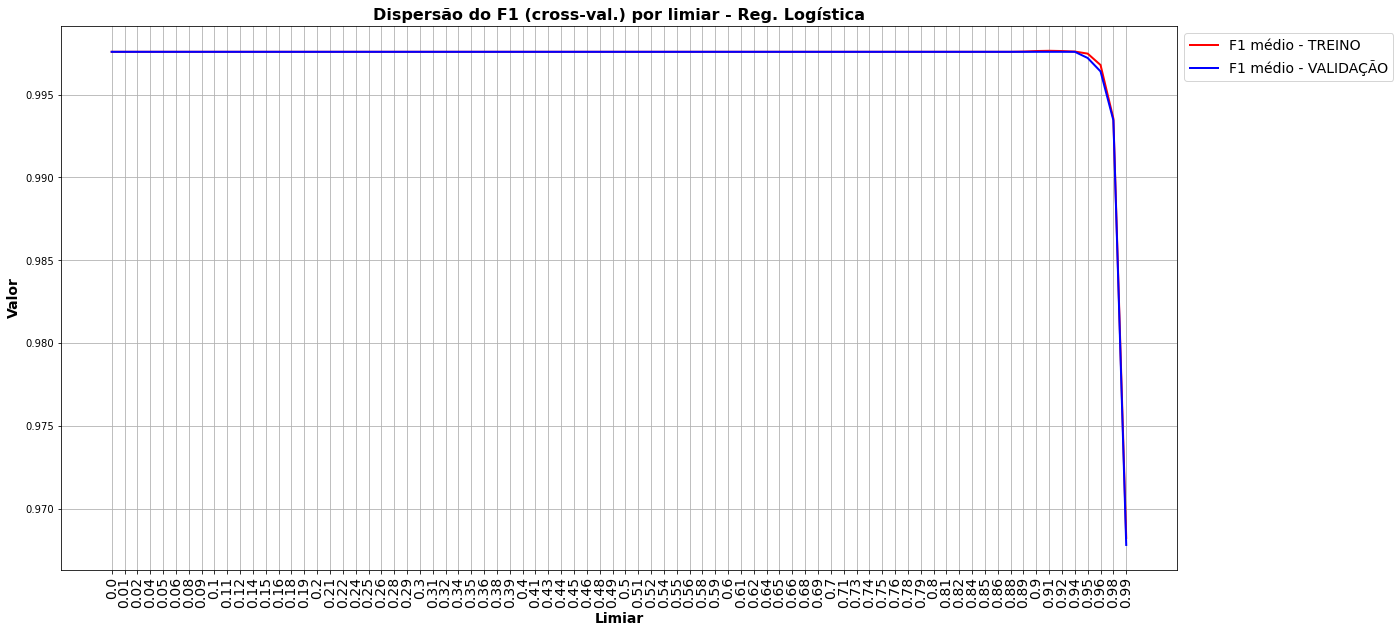

O valor máximo do F1 Score para o treino é 99.76426581581148 % para t = 0.9125000000000001

O valor máximo do F1 Score para a validação é 99.75803943471114 % para t = 0.0

Tempo de execução: 11.603504657745361 segundos.


In [46]:
threshold = np.arange(0, 1, 0.0125)

lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:
    
    lt, lv, cl = validacao_cruzada(classificador = LogisticRegression(), 
                               X_data = Xtrain_n, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14, rotation=90)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - Reg. Logística", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(np.max(lista_media_metrica_treino)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(np.max(lista_media_metrica_validacao)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

t1 = time.time()
print('Tempo de execução: %s segundos.' %(t1-t0))

Vemos que o resultado é bastante similar ao caso sem normalização. Para t = 0.5, obtemos as seguintes matrizes de confusão.

In [47]:
lt, lv, cl = validacao_cruzada(classificador = LogisticRegression(), 
                               X_data = Xtrain_n, 
                               y_data = ytrain, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = 0.5)
    
f1_treino = np.mean(lt)
f1_validacao = np.mean(lv)

print('O valor médio do F1 Score para os dados treino é ', end='')
print(str(f1_treino * 100) + ' %.')

print('O valor médio do F1 Score para os dados de validação é ', end='')
print(str(f1_validacao * 100) + ' %.')

y_pred_test = cl.predict(Xtest)
f1_test = f1_score(y_true = ytest, y_pred = y_pred_test)

print('O valor do F1 Score para os dados de teste é ', end='')
print(str(f1_test * 100) + ' %.')

O valor médio do F1 Score para os dados treino é 99.75807701606445 %.
O valor médio do F1 Score para os dados de validação é 99.75803943471114 %.
O valor do F1 Score para os dados de teste é 99.62732919254658 %.


In [48]:
cm_lg_tr = confusion_matrix(y_true = ytrain, y_pred = cl.predict(Xtrain))
df_cm_lg_tr = pd.DataFrame(np.c_[cm_lg_tr],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de treino')
df_cm_lg_tr

Matriz de confusão: Dados de treino


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,39
Sem anom. (R),0,8041


In [49]:
cm_lg = confusion_matrix(y_true = ytest, y_pred = y_pred_test)
df_cm_lg = pd.DataFrame(np.c_[cm_lg],
                     columns = ['Com anom. (P)', 'Sem anom. (P)'],
                     index = ['Com anom. (R)', 'Sem anom. (R)'])
print('Matriz de confusão: Dados de teste')
df_cm_lg

Matriz de confusão: Dados de teste


,Com anom. (P),Sem anom. (P)
Com anom. (R),0,15
Sem anom. (R),0,2005


Vemos que, independente da normalização, o modelo de regressão logística simples não é capaz de predizer quando há, ou não, uma anomalia. Uma possibilidade seria usar modelos de ordem superior, como polinômios de segunda ordem, por exemplo, ou até mesmo modelos de árvores de decisão, ou baseados em árvores de decisão, como ensambles.

Para os casos considerados na segunda parte do exercício, o único modelo que se mostrou capaz de predizer se há anomalia foi o KNN (K = 1), entretanto, quando comparado ao modelo basedo nas funções de densidade de probabilidade, vemos que a resposta do mesmo não é tão boa.

Além disso, percebe-se, também, que a métrica f1 score não é uma boa metodologia a ser utilizada, uma vez que a quantidade total de anomalias presentes é muito menor que o total de dados normais. O mesmo pode ser dito para os parâmetros accuracy, precision e recall. Apesar do comentário anterior, talvez o coeficiente accuracy fosse mais adequado à análise. A métrica f1 foi escolhida, pois na parte 1 do problema ela apresentou uma boa resposta aos dados, entretanto, na parte 2 vimos que apesar dos modelos testados apresentarem um alto valor para a métrica f1, os mesmos não foram capazes de identificar as anomalias.

__Dúvidas__: 

1. Qual seria a métrica mais indicada para esse tipo de análise? Na parte 1, f1 pareceu ser uma boa escolha, mas testando os modelos de classificação na parte 2, fica claro que não é a melhor.

2. No caso de anomalias, o modelo apresentado na parte 1 do exercício será o mais indicado? Poderia me indicar algum outro modelo para estudar?